# Laboratorium 4

Zaimplementować funkcję softmax dla warstwy wyjściowej sieci neuronowej. Sprawdzić szybkość i skuteczność w wariancie, gdy sieć używa funkcji softmax na ostatniej warstwie i gdy jest użyta zwykła funkcja aktywacji. **Softmax wymaga też odpowiednich zmian w algorytmie uczenia, uwzględniających pochodną fukcji.**

Przeprowadzić eksperymenty na zbiorach:

    rings3-regular,
    easy,
    xor3.




In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
import matplotlib

In [2]:
np.random.seed(420)

## Klasa mlp

In [96]:
class MLP:
    """
    layers - wektor zawierający liczbę kolejnych neuronów warstwach, w tym wejscie i wyjscie
    weights_biases - wybor metody losowania wag
    activation_function - funkcja aktywacji
    activation_function_dev - pochodna funkcja aktywacji
    delta_w, delta_b - zmiana biasu i wag w propagacji wstecznej 
    """
    
    
    def __init__(self, layers, weights_biases, activation_function, softmax_method = False):
        self.layers = layers
        self.softmax_method = softmax_method
        self.weights = []
        self.biases = []
        self.delta_w = []
        self.delta_b = []
        
        if activation_function == "sigmoid":
            self.activation_function = self.sigmoid
            self.activation_function_der = self.sigmoid_der

        if weights_biases == "Random":
            self.weights_random()
        elif weights_biases == "Xavier": 
            self.weights_xavier()
        
    def weights_random(self):
        """
        losowanie wag z rozkladu jednostajnego z przedzialu [-1,1] 
        """
        for i in range(len(self.layers) - 1):
            self.weights.append(np.random.uniform(
                -1, 1, self.layers[i] * self.layers[i + 1]).reshape(layers[i], self.layers[i + 1]))
            self.biases.append(np.random.uniform(-1, 1, self.layers[i + 1]).reshape(1, self.layers[i+1]))
            
    def weights_xavier(self):
        """
        losowanie wag metodą Xaviera
        """
        xavier = np.sqrt(6)/np.sqrt(self.layers[1]+self.layers[-1])
        for i in range(len(self.layers) - 1):
            self.weights.append(xavier * np.random.uniform(
                -1, 1, self.layers[i] * self.layers[i + 1]).reshape(layers[i], self.layers[i + 1]))
            self.biases.append(xavier * np.random.uniform(-1, 1, self.layers[i + 1]).reshape(1, self.layers[i+1]))

    
    def forward(self, inputs):
        """
        przejscie do przodu po sieci neuronowych
        """
        self.A = []
        self.z = []

        a = inputs
        self.A.append(a)
        for i in range(len(self.layers)-2):

            outputs = a @ self.weights[i] + self.biases[i]
            self.z.append(outputs)
            a = self.activation_function(outputs)
            self.A.append(a)
        results = a @ self.weights[-1] + self.biases[-1]
        if self.softmax_method == True:
            results = [self.softmax(i) for i in results]
        self.z.append(results)
        self.A.append(results)
        return results

    def backward(self, y):
        """
        propagacja wsteczna
        """
        m = y.shape[0]
        D = [None] * len(self.weights)
        D[-1] = y - self.A[-1]
        
        if self.softmax_method == True:
            D[-2] = ((self.weights[-1] @ D[-1].T ) * self.softmax(self.softmax_der(self.z[-2])).T).T
        
        for i in reversed(range(len(D) - 1 - int(self.softmax_method))):
            D[i] = ((self.weights[i + 1] @ D[i + 1].T ) * self.activation_function_der(self.z[i]).T).T


        delta_b = [None] * len(D)
        delta_w = [None] * len(D)

        for i, d in enumerate(D):
            delta_w[i] = (d.T @ self.A[i]).T / m
            delta_b[i] = (d.T @ np.ones((m, 1))).T / m

        return delta_w, delta_b

    def learn(self, x, y, batch_size=20, iterations=500, alpha=0.01, method = "Classic", var=0.4):
        """
        alpha - learning rate
        method - wybór metody uczenia Classic(default)/Momentum/RMSProp
        var - współczynnik wygaszania
        """
        
        p = np.random.permutation(len(x))
        x = x[p]
        y = y[p]
        
        method_w = [np.zeros(w.shape) for w in self.weights]
        method_b = [np.zeros(b.shape) for b in self.biases]

        for iteration in range(iterations):
            i = 0
            
            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                self.forward(x_batch)
                delta_w, delta_b = self.backward(y_batch)
                
                if method == "Classic":
                    for j, weight in enumerate(self.weights):    
                        self.weights[j] = weight + alpha * delta_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        self.biases[j] = bias + alpha * delta_b[j]   
                
                elif method == "Momentum":
                    for j, weight in enumerate(self.weights):    
                        method_w[j] = method_w[j] * var + delta_w[j]
                        self.weights[j] = weight + alpha * method_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = method_b[j] * var + delta_b[j]
                        self.biases[j] = bias + alpha * method_b[j]
                        
                elif method == "RMSProp":
                    for j, weight in enumerate(self.weights):    
                        method_w[j] = var * method_w[j] + (1-var) * delta_w[j] ** 2
                        self.weights[j] = weight + alpha * (delta_w[j]/np.sqrt(method_w[j]) + 10**-8)
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = var * method_b[j] + (1-var) * delta_b[j] ** 2
                        self.biases[j] = bias + alpha * (delta_b[j]/np.sqrt(method_b[j]) + 10**-8)
    def classify(self,x):
        probability = self.forward(x)
        return [i.argmax() for i in probability]
    
    
    @staticmethod
    def sigmoid(x):
        z = np.array(x)
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def sigmoid_der(x):
        def sigmoid(x):
            z = np.array(x)
            return 1 / (1 + np.exp(-z))
        return sigmoid(x) * (1 - sigmoid(x))
    
    @staticmethod
    def softmax(z):
        exps = np.exp(z)
        sums = np.sum(exps)
        return np.divide(exps, sums)
    
    @staticmethod
    def softmax_der(x):
        return (1-x)*x

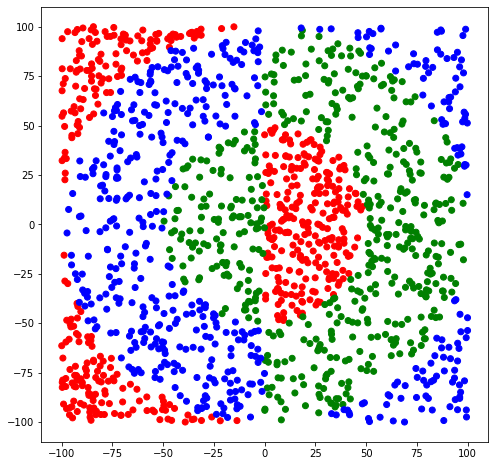

In [97]:
train_df = pd.read_csv('mio_data/classification/rings3-regular-training.csv')
test_df = pd.read_csv('mio_data/classification/rings3-regular-test.csv')

x = np.asarray(train_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
p = np.array([[1,0,0] if i == 0 else ([0,1,0] if i == 1 else [0,0,1]) for i in c])

colors = ['red','green','blue']
fig = plt.figure(figsize=(8,8))
plt.scatter(train_df['x'], train_df['y'], c=train_df['c'], cmap=matplotlib.colors.ListedColormap(colors))


In [102]:
layers = [2, 20, 3]
mlp = MLP(layers = layers, weights_biases = "Random", 
          activation_function = "sigmoid", softmax_method = False)

mlp.learn(x = x, y = p, alpha = 0.01, iterations = 1000, method = "Momentum", var =0.1)

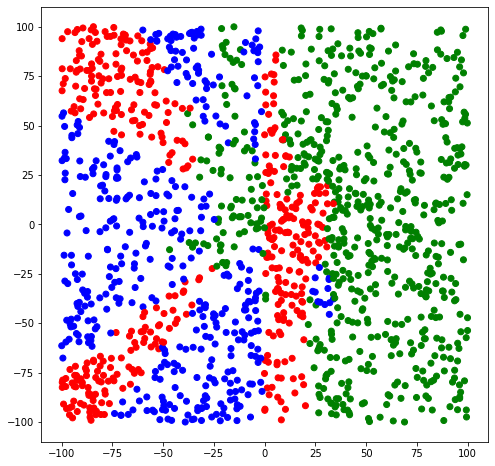

In [101]:
prob = mlp.classify(x)

fig = plt.figure(figsize=(8,8))
plt.scatter(train_df['x'], train_df['y'], c=prob, cmap=matplotlib.colors.ListedColormap(colors))

In [487]:
train_df = pd.read_csv('mio_data/classification/xor3-training.csv')
test_df = pd.read_csv('mio_data/classification/xor3-test.csv')

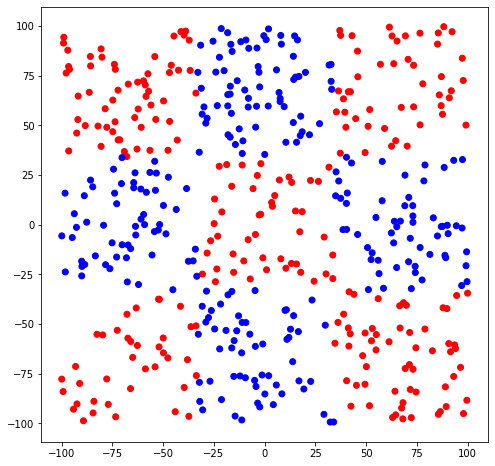

In [488]:
colors = ['red','green','blue']
fig = plt.figure(figsize=(8,8))
plt.scatter(train_df['x'], train_df['y'], c=train_df['c'], cmap=matplotlib.colors.ListedColormap(colors))

In [489]:
layers = [2, 10, 2]
mlp = MLP(layers = layers, weights_biases = "Random", 
          activation_function = sigmoid, activation_function_der = sigmoid_der)

x = np.asarray(train_df[['x', 'y']])
c = np.asarray(train_df['c']).reshape(-1, 1)
p = np.array([[1,0] if i == 0 else [0,1] for i in c])

mlp.learn(x = x, y = p, alpha = 0.01, iterations = 100)

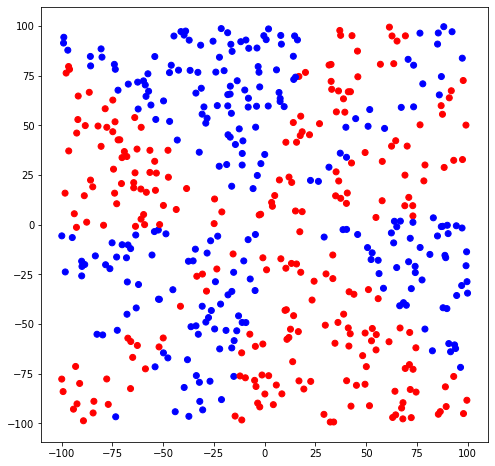

In [490]:
prob = mlp.classify(x)

fig = plt.figure(figsize=(8,8))
plt.scatter(train_df['x'], train_df['y'], c=prob, cmap=matplotlib.colors.ListedColormap(colors))